#### Taylor's Attempt (Updated Week #8)

In [ ]:
# Imports and initial setup
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Spotify authentication
client_credentials = SpotifyClientCredentials(client_id='97a92c7614f248d38952612def032c31', 
                                              client_secret='51f8eaebb63042678edbaf3d3a52f82c')
sp = spotipy.Spotify(client_credentials_manager=client_credentials)

In [ ]:
# Function to get track features from Spotify
def get_track_features(track_id):
    features = sp.audio_features([track_id])[0]
    if features is not None:
        # Features added
        return [features['danceability'], features['energy'], features['valence'], 
                features['acousticness'], features['tempo'], features['speechiness'], features['liveness']]
    return None

# Get track IDs for a specific mood
def get_tracks_for_mood(mood):
    results = sp.search(q=mood, type='track', limit=50)
    track_ids = [track['id'] for track in results['tracks']['items']]
    return track_ids

In [4]:
# Initialize lists to hold data
X = []
y = []

# Moods to search for
moods = ['happy', 'sad', 'relaxed', 'energetic']

# Fetch features for each mood
for mood in moods:
    track_ids = get_tracks_for_mood(mood)
    for track_id in track_ids:
        features = get_track_features(track_id)
        if features:
            X.append(features)
            y.append(mood)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert target labels to numerical values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [5]:
# Data augmentation function
def augment_data(X, y, n_augment=2):
    X_augmented = []
    y_augmented = []
    for i in range(len(X)):
        for _ in range(n_augment):
            noise = np.random.normal(0, 0.01, X[i].shape) 
            X_augmented.append(X[i] + noise)
            y_augmented.append(y[i])
    return np.array(X_augmented), np.array(y_augmented)

# Apply data augmentation
X_augmented, y_augmented = augment_data(X, y)
X_combined = np.vstack((X, X_augmented))
y_combined = np.concatenate((y, y_augmented))

In [6]:
# Split the augmented data into training, validation, and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Encode y_temp and y_test after data splitting
# *Causing errors*
# y_train = le.transform(y_train)
# y_val = le.transform(y_val)
# y_test = le.transform(y_test)

In [7]:
# Define neural network with regularization
mlp = MLPClassifier(
    hidden_layer_sizes=(20, 10),
    max_iter=2000,
    alpha=0.01,
    learning_rate_init=0.001,
    random_state=42
)

# Custom training loop with manual early stopping
train_losses = []
val_losses = []
best_val_loss = float("inf")
patience = 10  
patience_counter = 0

for epoch in range(2000):
    # Using original class labels (string)
    mlp.partial_fit(X_train, y_train, classes=le.classes_)
    
    if epoch % 100 == 0:
        train_loss = mlp.loss_
        train_losses.append(round(train_loss, 4))
        
        # Calc validation loss (integer encoding for indexing)
        val_loss = np.mean(1 - mlp.predict_proba(X_val)[np.arange(len(y_val)), le.transform(y_val)])
        val_losses.append(round(val_loss, 4))
        print(f"Epoch [{epoch}/2000], Train Loss: {train_loss}, Val Loss: {val_loss}")
        
        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Resets patience counter if improvement is seen (positive)
        else:
            patience_counter += 1  # Increase patience if no improvement is being made. Patience is set to 10 above!
            
        # Stop if validation loss has not improved for 'patience' epochs
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [0/2000], Train Loss: 1.5097339324164525, Val Loss: 0.7368404259104574
Epoch [100/2000], Train Loss: 1.0084933239459828, Val Loss: 0.5750023601680554
Epoch [200/2000], Train Loss: 0.8234615958512258, Val Loss: 0.4886886206272983
Epoch [300/2000], Train Loss: 0.7032945815692944, Val Loss: 0.4336346763605326
Epoch [400/2000], Train Loss: 0.6124642134887037, Val Loss: 0.39432491528419833
Epoch [500/2000], Train Loss: 0.5326504021646468, Val Loss: 0.35940629997379414
Epoch [600/2000], Train Loss: 0.46656159395374375, Val Loss: 0.3312639632139432
Epoch [700/2000], Train Loss: 0.40478342146435603, Val Loss: 0.30764661709105967
Epoch [800/2000], Train Loss: 0.3443268493165058, Val Loss: 0.2859064934941618
Epoch [900/2000], Train Loss: 0.287966659911022, Val Loss: 0.2632546813253652
Epoch [1000/2000], Train Loss: 0.23656162810802983, Val Loss: 0.24188302278316617
Epoch [1100/2000], Train Loss: 0.19364931001984648, Val Loss: 0.22029598259019065
Epoch [1200/2000], Train Loss: 0.15917791874

Test Accuracy: 0.8487
Classification Report:
               precision    recall  f1-score   support

   energetic       0.94      0.83      0.88        35
       happy       0.71      0.92      0.80        26
     relaxed       0.76      0.90      0.83        21
         sad       1.00      0.78      0.88        37

    accuracy                           0.85       119
   macro avg       0.85      0.86      0.85       119
weighted avg       0.87      0.85      0.85       119



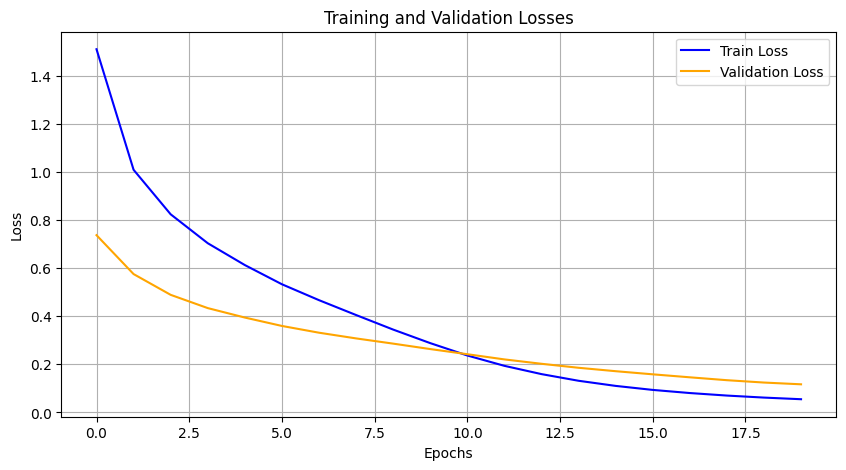

In [8]:
# Evaluate the MLP model on test set
y_pred_mlp = mlp.predict(X_test)
test_accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"Test Accuracy: {test_accuracy_mlp:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_mlp, target_names=le.classes_))

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()


In [9]:
from sklearn.metrics import classification_report, confusion_matrix # Though, these are probably imported above 

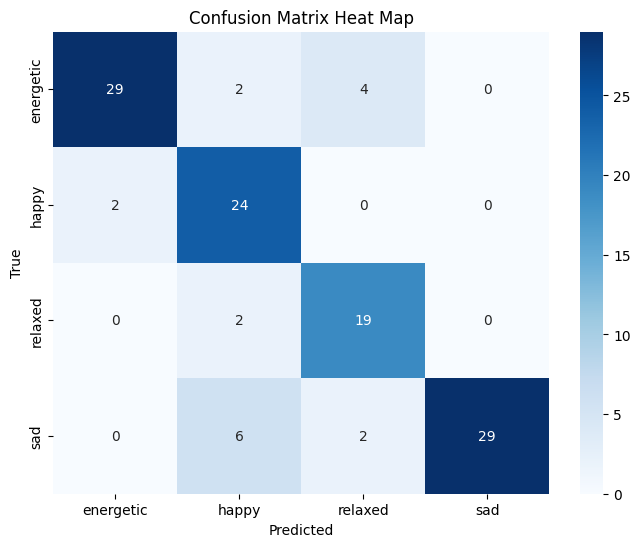

In [10]:
# Get predictions on the test set
y_pred = mlp.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=le.classes_)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heat Map')
plt.show()

In [11]:
# Generate classification report as a fun dictionary
report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)

# Convert the dictionary to a dataframe for better readability (fun)
report_df = pd.DataFrame(report_dict).transpose()

# Display the DataFrame
report_df.style.set_caption("Classification Report Metrics").format("{:.2f}")

,precision,recall,f1-score,support
energetic,0.94,0.83,0.88,35.00
happy,0.71,0.92,0.80,26.00
relaxed,0.76,0.90,0.83,21.00
sad,1.00,0.78,0.88,37.00
accuracy,0.85,0.85,0.85,0.85
macro avg,0.85,0.86,0.85,119.00
weighted avg,0.87,0.85,0.85,119.00


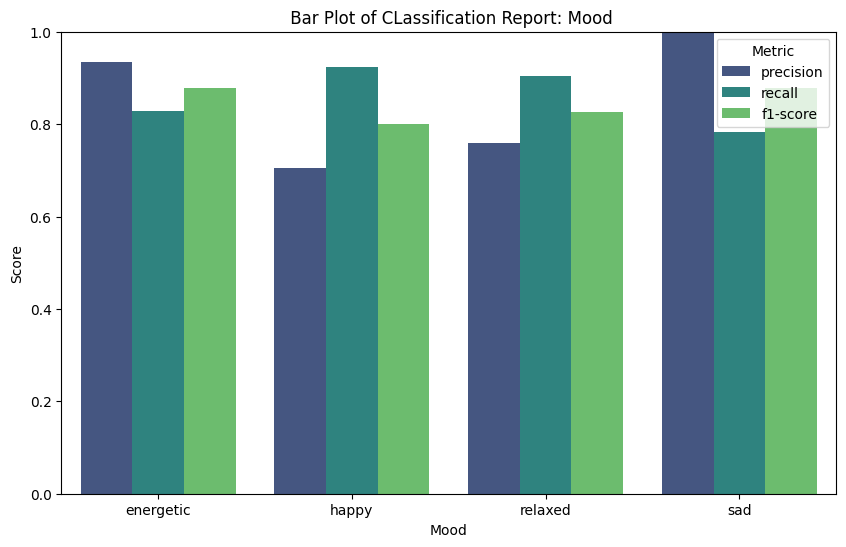

In [12]:
# Create the classification report DataFrame (if it did not convert properly above)
report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().iloc[:-3, :3] 

# Melt the dataframe (for easier plotting)
report_melted = report_df.reset_index().melt(id_vars="index", value_vars=["precision", "recall", "f1-score"])
report_melted.columns = ["Mood", "Metric", "Score"]

# Plot precision, recall, and F1-score for each mood
plt.figure(figsize=(10, 6))
sns.barplot(x="Mood", y="Score", hue="Metric", data=report_melted, palette="viridis")
plt.title(" Bar Plot of CLassification Report: Mood")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(title="Metric")
plt.show()

C:\Users\tpete\AppData\Local\Temp\ipykernel_1604\2180930081.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=features, y=mean_abs_weights, palette="coolwarm")


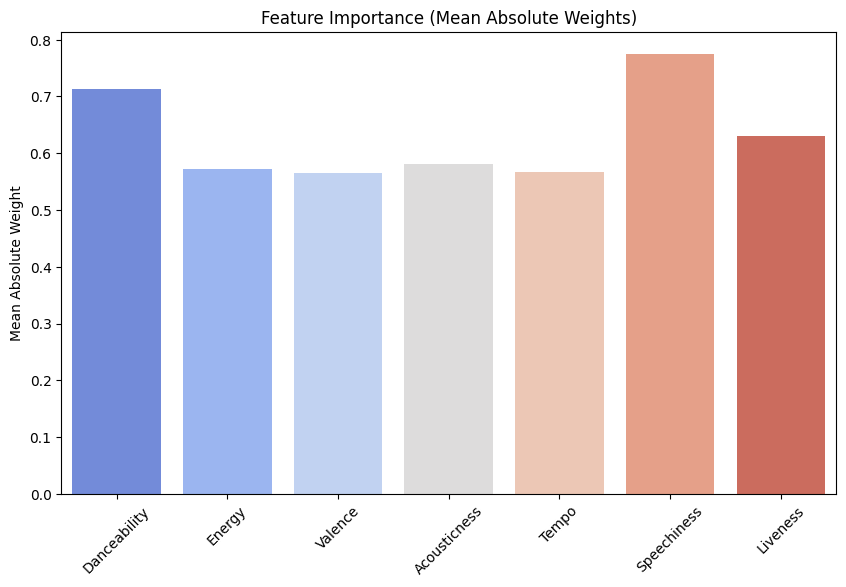

In [13]:
# Calculate the mean absolute weight for each feature in the first layer
mean_abs_weights = np.mean(np.abs(mlp.coefs_[0]), axis=1)

# Plot the feature importance
features = ['Danceability', 'Energy', 'Valence', 'Acousticness', 'Tempo', 'Speechiness', 'Liveness']
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=mean_abs_weights, palette="coolwarm")
plt.title("Feature Importance (Mean Absolute Weights)")
plt.ylabel("Mean Absolute Weight")
plt.xticks(rotation=45)
plt.show()

In [14]:
# Define and train Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train, y_train)

# Evaluate the Random Forest model
y_pred_rf = rf.predict(X_test)
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Test Accuracy: {test_accuracy_rf:.4f}")
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf, target_names=le.classes_))

Random Forest Test Accuracy: 0.8992

Random Forest Classification Report:
               precision    recall  f1-score   support

   energetic       1.00      0.94      0.97        35
       happy       0.75      0.92      0.83        26
     relaxed       1.00      1.00      1.00        21
         sad       0.88      0.78      0.83        37

    accuracy                           0.90       119
   macro avg       0.91      0.91      0.91       119
weighted avg       0.91      0.90      0.90       119



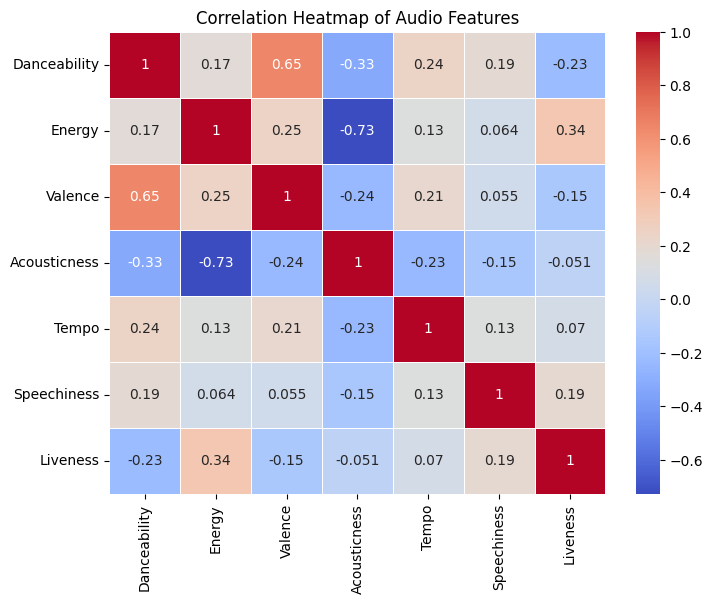

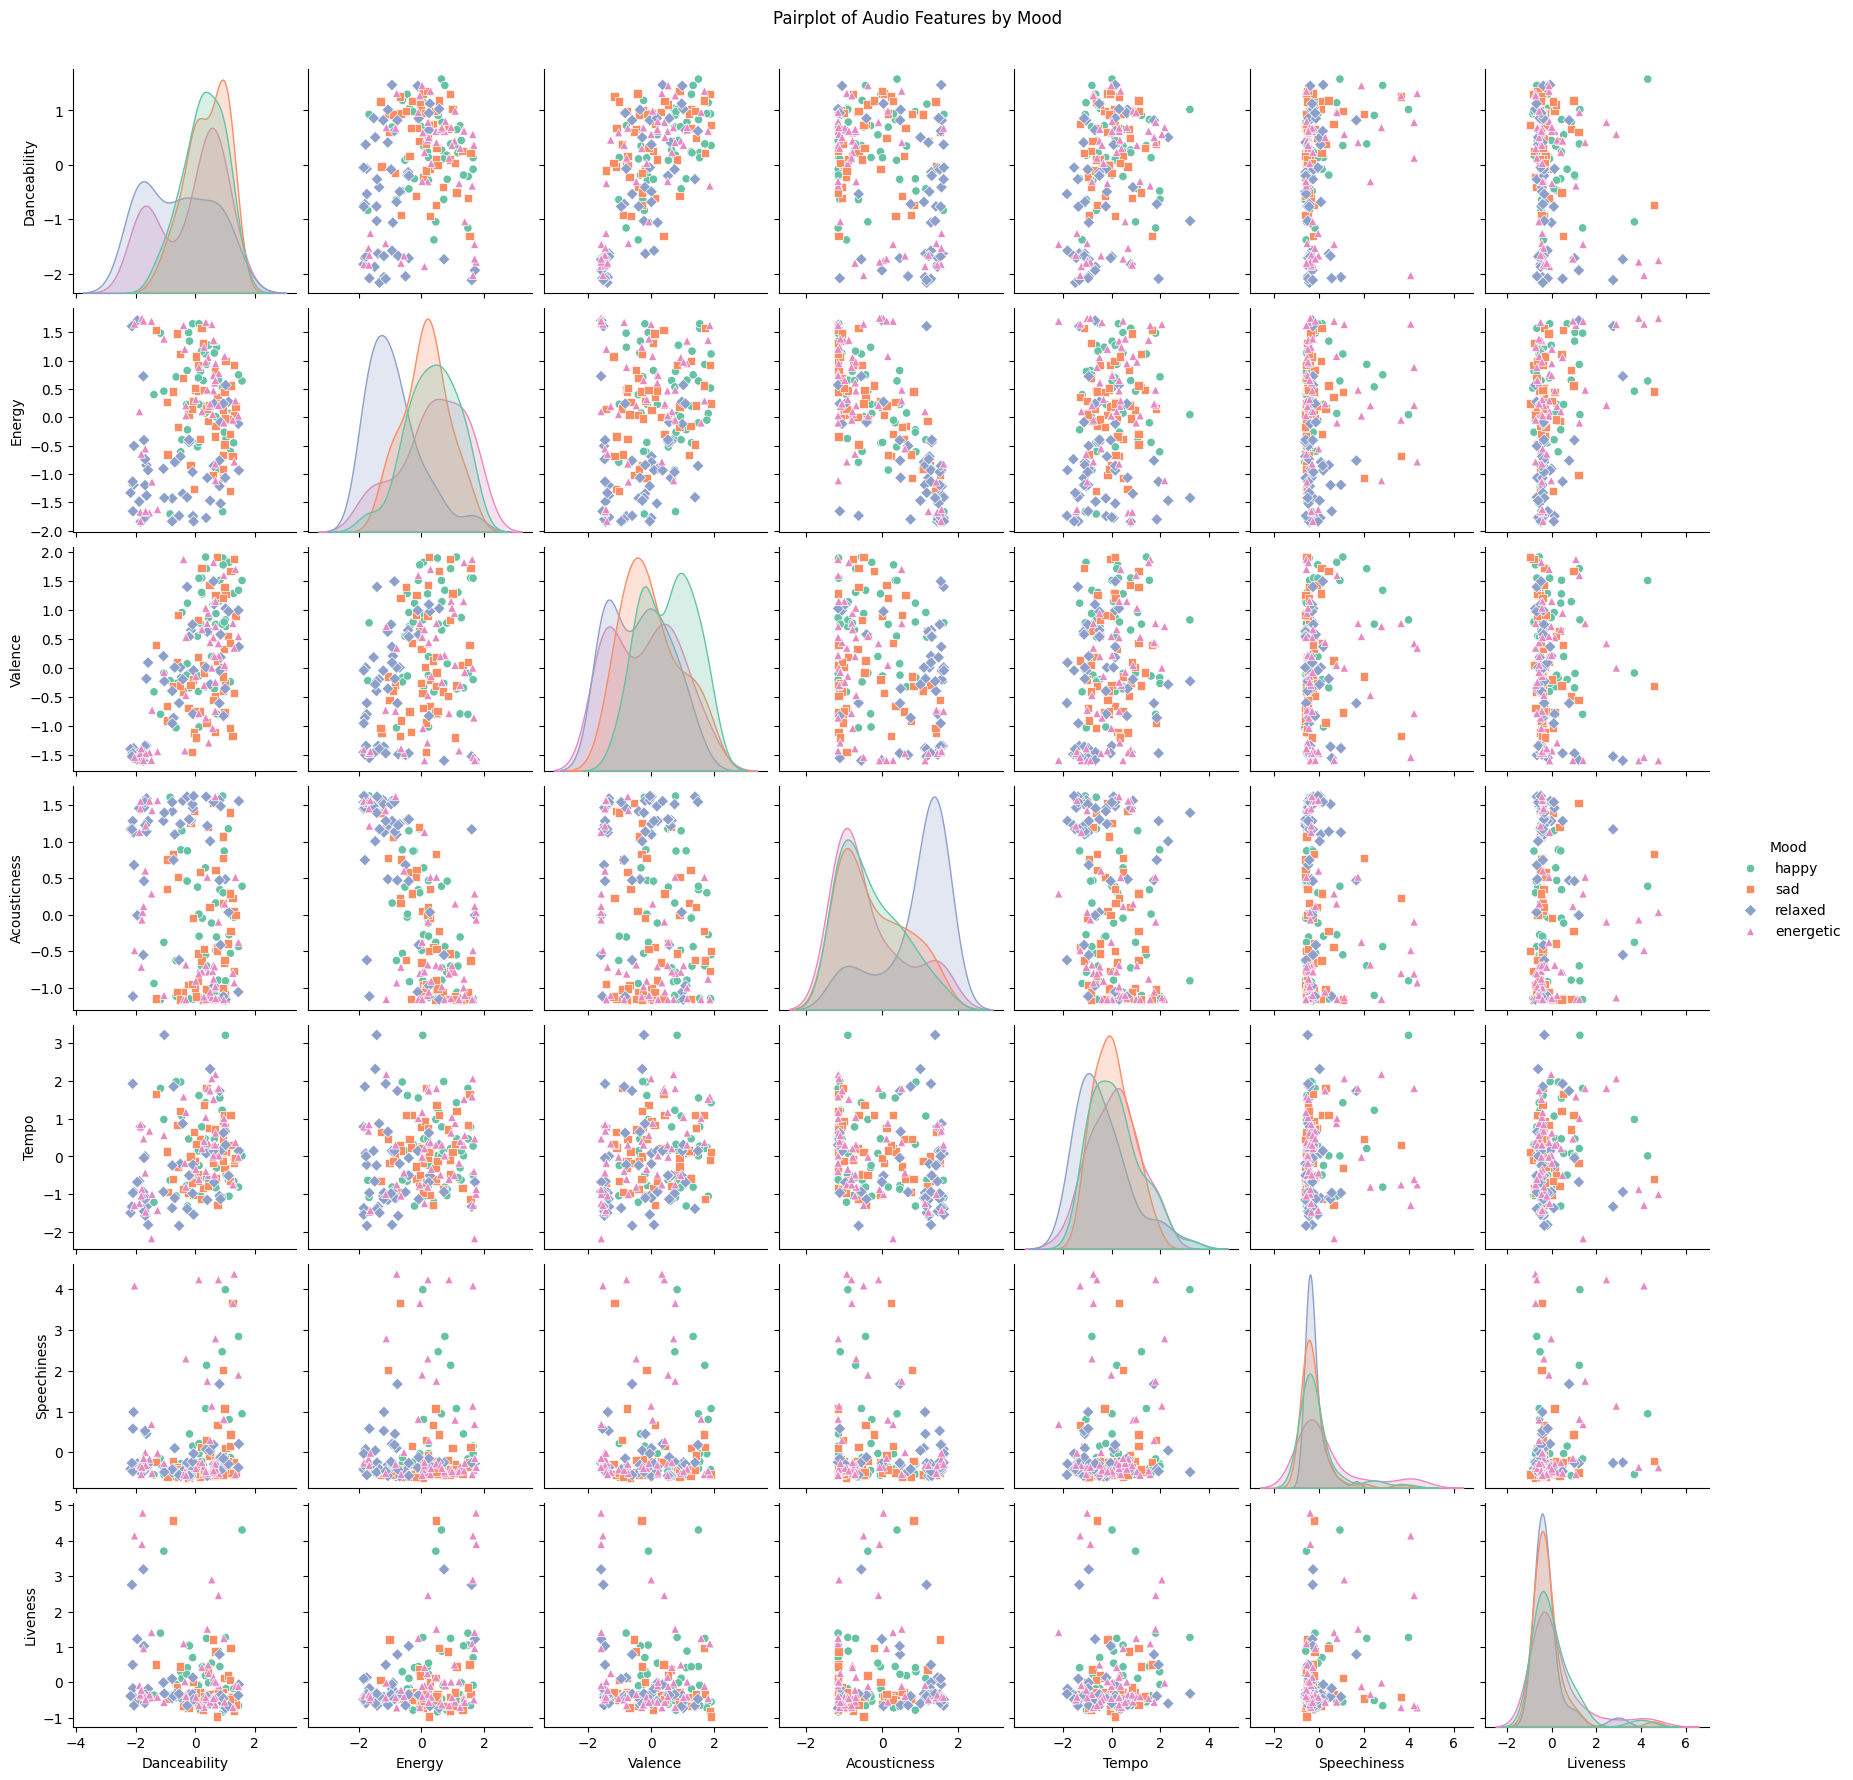

In [15]:
# Enhanced correlation heatmap with new feature set
feature_df = pd.DataFrame(X, columns=['Danceability', 'Energy', 'Valence', 'Acousticness', 'Tempo', 'Speechiness', 'Liveness'])
feature_df['Mood'] = y

# Corelation matrix heatmap
corr_matrix = feature_df.drop(columns=['Mood']).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Audio Features')
plt.show()

# Pairplot (further visualize features and mood)
feature_df['Mood'] = pd.Categorical(feature_df['Mood'], categories=moods, ordered=True)
sns.pairplot(feature_df, hue='Mood', diag_kind='kde', palette='Set2', markers=["o", "s", "D", "^"])
plt.suptitle("Pairplot of Audio Features by Mood", y=1.02)
plt.show()